In [267]:
import numpy as np
import imp
import sys
import os
import time
sys.path.append(os.path.expanduser('~/quantum-ml/nanowire_model'))
import copy
import potential_profile

import multiprocessing as mp

import markov
import physics
import thomas_fermi
import mask
import tunneling
import exceptions

imp.reload(tunneling)
imp.reload(markov)
imp.reload(physics)
imp.reload(thomas_fermi)
imp.reload(mask)
imp.reload(potential_profile)
imp.reload(exceptions)

physics_model = {}
# multiple of eV
physics_model['E_scale'] = 1
# multiple of nm
physics_model['dx_scale'] = 1

physics_model['kT'] = 1000e-6

b1 = (-200e-3,-0.3,0.1,1)
d = (20e-3,0.0,0.1,1)
b2 = (-200e-3,0.3,0.1,1)

x = np.linspace(-1,1,100)
physics_model['x'] = x
physics_model['V'] = potential_profile.V_x_wire(x,[b1,d,b2])

physics_model['K_onsite'] = 5e-3
physics_model['sigma'] = x[1] - x[0]
physics_model['x_0'] = 0.1*(x[1] - x[0])
physics_model['mu_l'] = (100.0e-3,100.1e-3)
physics_model['battery_weight'] = 10
physics_model['short_circuit_current'] = 1

graph_model = (25,1)
tf_strategy = 'simple'

#timeit my_phys = physics.Physics(physics_model)
#%lprun -f physics.Physics.__init__ my_phys = physics.Physics(physics_model)

#timeit graph = markov.Markov(graph_model,physics_model,tf_strategy)
#%lprun -f thomas_fermi.ThomasFermi.tf_solver_fixed_mu graph = markov.Markov(graph_model,physics_model,tf_strategy)

st = time.time()
graph = markov.Markov(graph_model,physics_model,tf_strategy)
print(graph.find_n_dot_estimate())
print(graph.find_start_node())
print(graph.recalculate_graph)
graph.generate_graph()
print(graph.get_current())
print(graph.get_charge_state())
print("time",time.time()-st)



0
(0, 1)
True
0.00177057852745
()
time 0.08813595771789551


In [ ]:
graph.G.nodes(data=True)


In [ ]:
graph.G.edges(data=True)

In [ ]:
plt.plot(graph.tf.V)

In [345]:
def calculate_current(param):
    graph = param[0]
    physics_model = param[1]
    try:
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate(fix_mask=False)
        graph.find_start_node()
        graph.generate_graph()
        return graph.get_output()
    except exceptions.NoBarrierState:
        output = {}
        output['current'] = graph.tf.short_circuit_current
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'ShortCircuit'
        return output
    except exceptions.InvalidChargeState:
        output = {}
        output['current'] = 0
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'NoDot'
        return output
    
def calculate_curr_parr(physics_model):
    graph_model = (10,1)
    tf_strategy = 'simple_iter'
    
    try: 
        graph = markov.Markov(graph_model,physics_model,tf_strategy)
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate(fix_mask=False)
        graph.find_start_node()
        graph.generate_graph()
        I = graph.get_output()
        del graph
        return I
    except exceptions.NoBarrierState:
        return graph.tf.short_circuit_current

In [355]:
-

st = time.time()
num_proc = 5
num_batches = int(N_v/num_proc)

manager = mp.Manager()
return_dict = manager.dict()

def dummy(a,b,c):
    print(a,"apple")
    return

#for j in range(1):
#    jobs = []
#    for i in range(num_proc):
#        p = mp.Process(target=dummy, args=(j*num_proc + i,input_vec[j*num_proc + i],return_dict))
#        jobs.append(p)
#        p.start()
#    for proc in jobs:
#        proc.join()

output_vec = [calculate_current(x) for x in input_vec]
#output_vec = [*map(calculate_current,input_vec)]
#print(output_vec.get())
print("time",time.time() - st)
print(return_dict.values())

time 1009.7618951797485
[]


In [178]:
print(output_vec)



[{'num_dot': 0, 'prob_dist': (0,), 'charge_state': (0,), 'current': 0.001}]


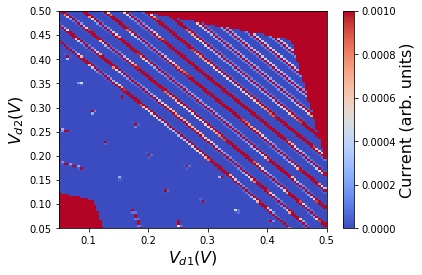

In [357]:
XX,YY = np.meshgrid(V_d_vec,V_d_vec)
plt.pcolor(XX,YY,np.array([x['current'] if x['current'] != None else 0.0 for x in output_vec]).reshape((N_v,N_v)),\
           cmap='coolwarm',vmax=1e-3)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar()
cbar.set_label("Current (arb. units)",fontsize=16)

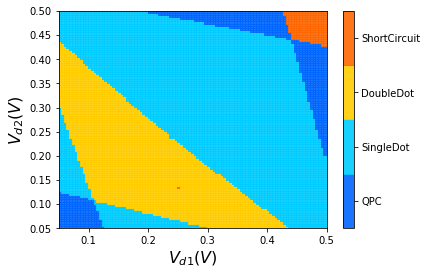

In [358]:
XX,YY = np.meshgrid(V_d_vec,V_d_vec)
def map_state_to_color(param):
    (state,num_dot) = param
    if state == 'QPC':
        return 0
    elif state == 'Dot' and num_dot == 1:
        return 1
    elif state == 'Dot' and num_dot == 2:
        return 2
    elif state == 'ShortCircuit':
        return 3
    else:
        return 4
C = [map_state_to_color(x) for x in zip([y['state'] for y in output_vec],[y['num_dot'] for y in output_vec])]
import matplotlib as mpl
my_cmap = mpl.colors.ListedColormap([[0., .4, 1.], [0., .8, 1.],
                                  [1., .8, 0.], [1., .4, 0.]])
C_new = [C[N_v*i : N_v*(i+1)] for i in range(N_v)]
plt.pcolor(XX,YY,C_new,cmap = my_cmap,alpha=0.9)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar(cmap=my_cmap,ticks=[0,1,2,3])
cbar.set_ticklabels(["QPC","SingleDot","DoubleDot","ShortCircuit"])
cbar.set_ticks([0.5,1.5,2.5,3.5])

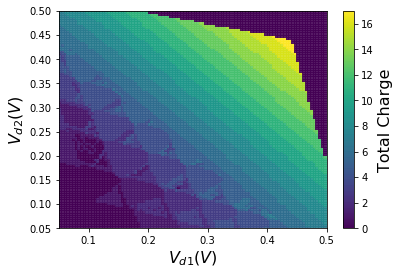

In [359]:
plt.pcolor(XX,YY,np.array([np.sum(x['charge_state']) if x['charge_state'] != None else 0.0 for x in output_vec]).reshape((N_v,N_v)),alpha=0.9)
plt.xlabel(r'$V_{d1} (V)$',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Total Charge',fontsize=16)

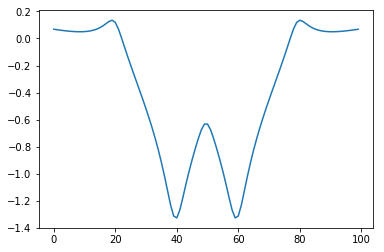

In [351]:
b1 = (-200e-3,-0.6,0.05,1)
d1 = (50e-3,-0.2,0.05,1)
b2 = (-300e-3,0.0,0.05,1)
d2 = (50e-3,0.2,0.05,1)
b3 = (-200e-3,0.6,0.05,1)


x = np.linspace(-1,1,15)
physics_model['x'] = x
#physics_model['V'] = potential_profile.V_x_wire(x,[b1,d1,b2,d2,b3])
plt.plot(physics_model['V'])

#graph = markov.Markov(graph_model,physics_model,tf_strategy)
#graph.find_n_dot_estimate()

In [217]:
p.terminate()


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import networkx as nx
[x for x in nx.get_edge_attributes(graph.G,"battery_edge") if x[0] == True]

[]

In [70]:
nx.get_edge_attributes(graph.G,"battery_edge")[((7, 0, 6), (6, 1, 6))]

False

In [99]:
set([x[1:-1] for x in graph.G.nodes()])

{(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (21,)}

In [138]:
p = Pool(3)

def f(x,y):
    return x*y
res = p.starmap(f,[(1,1),(2,2),(3,3),(4,4),(5,5)])
p.close()

In [210]:
output_vec.get()

KeyboardInterrupt: 

Process ForkPoolWorker-591:
Process ForkPoolWorker-593:
Process ForkPoolWorker-595:
Process ForkPoolWorker-588:
Process ForkPoolWorker-590:
Process ForkPoolWorker-587:
Process ForkPoolWorker-586:
Process ForkPoolWorker-592:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.

In [ ]:
print(output_vec)

In [172]:
tic = time.time()
res = [*map(calculate_curr_parr,input_vec)]
print(time.time() - tic)

23.30935788154602


In [194]:
output_vec

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]